# Testing optimization by random search

In [1]:
import numpy

In [2]:
import sklearn

In [3]:
import survhive

In [4]:
X, y = survhive.load_test_data()
X.shape, y.shape

((198, 84), (198,))

### Generate a (stratified) train-test split and Scale the features (only) 

First do the stratified splitting THEN do scaling, parameterized on X_train set ONLY 

In [5]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [6]:
X_train, X_test, y_train, y_test = survhive.survival_train_test_split(X, y,rng_seed=2309)

In [7]:
scaler = StandardScaler().fit(X_train)
[X_train, X_test] = [ scaler.transform(_) for _ in  [X_train, X_test] ]
X_train.shape, X_test.shape

((148, 84), (50, 84))

In [8]:
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

balanced partitioning OK. Robst scaler damages the performance of DSM A LOT.
maybe did something wrong. It is standard scaler for now.

In [9]:
survhive.get_indicator(y).sum(), survhive.get_indicator(y_train).sum(), survhive.get_indicator(y_test).sum(),


(51, 38, 13)

In [10]:
splitter = survhive.survival_crossval_splitter(X_train,y_train,n_splits=3, n_repeats=2,rng_seed=2309)
print([ (survhive.get_indicator(y_train[_[1]]).sum()) for _ in splitter])

[13, 12, 13, 13, 12, 13]


## check possible dimensionality reduction

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca= PCA(n_components=0.995, random_state=2308).fit(X_train)
pca.n_components_

74

Only a modest dimensionality reduction is possible using PCA

In [13]:
## Stratified CV spliter for survival analysis

In [14]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

# test coxnet

In [15]:
coxnet = survhive.CoxNet(rng_seed=2309)
coxnet.fit(X_train, y_train)

CoxNet(rng_seed=2309, l1_ratio=0.5, fit_baseline_model=False)

In [16]:
coxnet.score(X_test, y_test)

0.5775193798449613

In [17]:
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [18]:
survhive.optimization._guess_tries(survhive.CoxNet.get_parameter_grid())

1

In [19]:
survhive.CoxNet().get_parameter_grid()

{'l1_ratio': [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]}

In [20]:
from survhive import optimize

In [21]:
opt_coxnet, opt_coxnet_params, opt_coxnet_search = optimize(survhive.CoxNet(rng_seed=2309), X_train, y_train, mode='sklearn-random')
opt_coxnet.score(X_test, y_test), opt_coxnet_params

Random search tries: 1


(0.5910852713178295, {'l1_ratio': 0.99})

In [22]:
opt_coxnet, opt_coxnet_params, opt_coxnet_search = optimize(survhive.CoxNet(rng_seed=2309), X_train, y_train)
opt_coxnet.score(X_test, y_test), opt_coxnet_params

(0.5949612403100775, {'l1_ratio': 0.01})

In [23]:
def test_model(model_constructor, **model_params):
    m = model_constructor(**model_params)
    m.fit(X_train, y_train)
    o = m.score(X_train, y_train)
    s = m.score(X_test, y_test)
    print(f'Train: {o: .4f} , Test: {s:.4f}')
    return s

## Test RSF

In [24]:
rsf=survhive.RSF(rng_seed=2309)
rsf

RSF(rng_seed=2309, n_estimators=100, max_depth=None, min_samples_split=0.1, min_samples_leaf=0.05)

In [25]:
rsf.fit(X_train,y_train)
rsf.score(X_test,y_test)

0.6802325581395349

In [26]:
rsf_grid = rsf.get_parameter_grid()
rsf_grid['n_estimators']=[50,100,200,300]
rsf_grid['min_samples_split']=[0.1, 0.05]
rsf_grid['min_samples_leaf']=[0.05, 0.02]
rsf_grid

{'n_estimators': [50, 100, 200, 300],
 'max_depth': [None],
 'min_samples_split': [0.1, 0.05],
 'min_samples_leaf': [0.05, 0.02]}

In [27]:
opt_rsf, opt_rsf_params, opt_rsf_search = optimize(survhive.RSF(rng_seed=2309), X_train, y_train, user_grid=rsf_grid, n_jobs=4)
#opt_rsf, opt_rsf_params, opt_rsf_search = optimize(survhive.RSF(rng_seed=2309), X_train, y_train, n_jobs=4)
opt_rsf.score(X_train, y_train), opt_rsf.score(X_test, y_test), opt_rsf_params

(0.9515011547344111,
 0.6821705426356589,
 {'max_depth': None,
  'min_samples_leaf': 0.05,
  'min_samples_split': 0.1,
  'n_estimators': 200})

In [30]:
survhive.get_top_models(opt_rsf_search)

[(1,
  0.6862727228138205,
  0.10179857980253813,
  {'max_depth': None,
   'min_samples_leaf': 0.05,
   'min_samples_split': 0.1,
   'n_estimators': 200}),
 (1,
  0.6862727228138205,
  0.10179857980253813,
  {'max_depth': None,
   'min_samples_leaf': 0.05,
   'min_samples_split': 0.05,
   'n_estimators': 200}),
 (3,
  0.6842178116761294,
  0.11025692264427374,
  {'max_depth': None,
   'min_samples_leaf': 0.05,
   'min_samples_split': 0.1,
   'n_estimators': 100}),
 (3,
  0.6842178116761294,
  0.11025692264427374,
  {'max_depth': None,
   'min_samples_leaf': 0.05,
   'min_samples_split': 0.05,
   'n_estimators': 100}),
 (5,
  0.6827938824928792,
  0.09906572098459482,
  {'max_depth': None,
   'min_samples_leaf': 0.05,
   'min_samples_split': 0.1,
   'n_estimators': 300}),
 (5,
  0.6827938824928792,
  0.09906572098459482,
  {'max_depth': None,
   'min_samples_leaf': 0.05,
   'min_samples_split': 0.05,
   'n_estimators': 300}),
 (7,
  0.6714392553775272,
  0.1048767669612342,
  {'max_dept

# Test DSM

In [27]:
grid =survhive.DeepSurvivalMachines.get_parameter_grid(max_width=84)
grid

{'n_distr': [1, 2, 3],
 'distr_kind': ['Weibull'],
 'batch_size': [16, 32],
 'layer_sizes': [[3],
  [4],
  [5],
  [7],
  [9],
  [11],
  [14],
  [19],
  [24],
  [32],
  [41],
  [54],
  [70],
  [3, 3],
  [4, 4],
  [5, 5],
  [7, 7],
  [9, 9],
  [11, 11],
  [14, 14],
  [19, 19],
  [24, 24],
  [32, 32],
  [41, 41],
  [54, 54],
  [70, 70],
  [3, 3, 3],
  [4, 4, 4],
  [5, 5, 5],
  [7, 7, 7],
  [9, 9, 9],
  [11, 11, 11],
  [14, 14, 14],
  [19, 19, 19],
  [24, 24, 24],
  [32, 32, 32],
  [41, 41, 41],
  [54, 54, 54],
  [70, 70, 70]],
 'learning_rate': [0.005, 0.001],
 'validation_size': [0.1],
 'max_epochs': [100],
 'elbo': [False]}

In [37]:
dsm_tries = survhive.optimization._guess_tries(grid)
dsm_tries

24

In [46]:
%%timeit -c -n 1 -r 10
test_model(survhive.DeepSurvivalMachines, batch_size=16, layer_sizes=[5]*5, n_distr=2, max_epochs=200)

 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 40.46it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 41.84it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 41.92it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 40.36it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 44.81it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 43.61it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 39.64it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 41.58it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 42.31it/s]


Train:  0.9187 , Test: 0.6977


 24%|███████████████████████████████▌                                                                                                 | 49/200 [00:01<00:03, 41.77it/s]

Train:  0.9187 , Test: 0.6977
8 s ± 155 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [33]:
# Non stratified CV
#opt_dsm, opt_dsm_params, opt_dsm_search = optimize(survhive.DeepSurvivalMachines(rng_seed=2308),  X_train, y_train, 
#                                                   user_grid=grid,cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=2308))
#opt_dsm.score(X_test, y_test), opt_dsm_params

In [47]:
#estimated run time (s)
8 * dsm_tries *10 / 3

640.0

In [40]:
# Stratified CV
%timeit -c -n 1 -r 1
opt_dsm, opt_dsm_params, opt_dsm_search = optimize(survhive.DeepSurvivalMachines(rng_seed=2309),  X_train, y_train, mode='sklearn-random', n_jobs=3)
opt_dsm.score(X_test, y_test), opt_dsm_params

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 20.7 µs
Random search tries: 24


 15%|█▌        | 1522/10000 [00:01<00:07, 1141.62it/s]/usr/local/ivan/Unito/conda/envs/tosa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/ivan/Unito/conda/envs/tosa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/ivan/Unito/conda/envs/tosa/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/usr/local/ivan/Unito/survhive/survhive/auton_adapters.py", line 96, in score
    return self.harrell_score(y, self.predict(X))[0]
  File "/usr/local/ivan/Unito/survhive/survhive/auton_adapters.py", line 84, in harrell_score
    return concordance_index_censored(
  File "/usr/local/ivan/Unito/conda/envs/tosa

(0.6569767441860465,
 {'validation_size': 0.1,
  'n_distr': 3,
  'max_epochs': 100,
  'learning_rate': 0.005,
  'layer_sizes': [14],
  'elbo': False,
  'distr_kind': 'Weibull',
  'batch_size': 32})

In [48]:
survhive.get_top_models(opt_dsm_search)

[(1,
  0.7178400452138914,
  0.08219866560146068,
  {'validation_size': 0.1,
   'n_distr': 3,
   'max_epochs': 100,
   'learning_rate': 0.005,
   'layer_sizes': [14],
   'elbo': False,
   'distr_kind': 'Weibull',
   'batch_size': 32}),
 (2,
  0.7025732609869164,
  0.05443553005684397,
  {'validation_size': 0.1,
   'n_distr': 1,
   'max_epochs': 100,
   'learning_rate': 0.001,
   'layer_sizes': [7],
   'elbo': False,
   'distr_kind': 'Weibull',
   'batch_size': 16}),
 (3,
  0.6981069375027897,
  0.08080460271100312,
  {'validation_size': 0.1,
   'n_distr': 2,
   'max_epochs': 100,
   'learning_rate': 0.005,
   'layer_sizes': [54, 54],
   'elbo': False,
   'distr_kind': 'Weibull',
   'batch_size': 32}),
 (4,
  0.6892322568102879,
  0.08074688500877836,
  {'validation_size': 0.1,
   'n_distr': 1,
   'max_epochs': 100,
   'learning_rate': 0.005,
   'layer_sizes': [5],
   'elbo': False,
   'distr_kind': 'Weibull',
   'batch_size': 16}),
 (5,
  0.68480125131138,
  0.12770012028028363,
  {'va

In [49]:
test_model(survhive.DeepSurvivalMachines, batch_size=16, layer_sizes=[7], n_distr=1, max_epochs=200)

 16%|███████████████████▉                                                                                                             | 31/200 [00:00<00:03, 51.10it/s]

Train:  0.9224 , Test: 0.7112


0.7112403100775194

# PyCox

In [55]:
#import pycox.models

In [28]:
dhs = survhive.DeepHitSingle(rng_seed=2309)
dhs

DeepHitSingle(rng_seed=2309, num_durations=10, layer_sizes=[10, 10], epochs=10, batch_size=16, validation_size=0.1, learning_rate=0.001, dropout=0.1, device='cpu')

In [29]:
dhs_grid = survhive.DeepHitSingle().get_parameter_grid(max_width=84)
dhs_grid

{'num_durations': [10],
 'layer_sizes': [[3],
  [4],
  [5],
  [7],
  [9],
  [11],
  [14],
  [19],
  [24],
  [32],
  [41],
  [54],
  [70],
  [3, 3],
  [4, 4],
  [5, 5],
  [7, 7],
  [9, 9],
  [11, 11],
  [14, 14],
  [19, 19],
  [24, 24],
  [32, 32],
  [41, 41],
  [54, 54],
  [70, 70],
  [3, 3, 3],
  [4, 4, 4],
  [5, 5, 5],
  [7, 7, 7],
  [9, 9, 9],
  [11, 11, 11],
  [14, 14, 14],
  [19, 19, 19],
  [24, 24, 24],
  [32, 32, 32],
  [41, 41, 41],
  [54, 54, 54],
  [70, 70, 70]],
 'epochs': [100],
 'batch_size': [16, 32],
 'validation_size': [0.1]}

In [31]:
%%timeit -n 1 -r 10
test_model(survhive.DeepHitSingle, rng_seed=2309, num_durations=10, validation_size=None, learning_rate=0.005,  epochs=100, layer_sizes=[7,7])

Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
Train:  0.6871 , Test: 0.5136
366 ms ± 88.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [32]:
dhs_tries = survhive.optimization._guess_tries(dhs_grid)
dhs_tries

4

In [86]:
#estimated run time (s)
0.5 * dhs_tries *10  #default fraction is 0.05 

120.0

In [33]:
# Stratified CV
%timeit -c -n 1 -r 1
opt_dhs, opt_dhs_params, opt_dhs_search = optimize(survhive.DeepHitSingle(rng_seed=2309),  X_train, y_train, mode='sklearn-random' , tries=25)
opt_dhs.score(X_test, y_test), opt_dhs_params

Random search tries: 25


(0.5058139534883721,
 {'validation_size': 0.1,
  'num_durations': 10,
  'layer_sizes': [24, 24],
  'epochs': 100,
  'batch_size': 32})

In [34]:
test_model(survhive.DeepHitSingle, **opt_dhs_params, rng_seed=2309)

Train:  0.7644 , Test: 0.5058


0.5058139534883721

<Axes: >

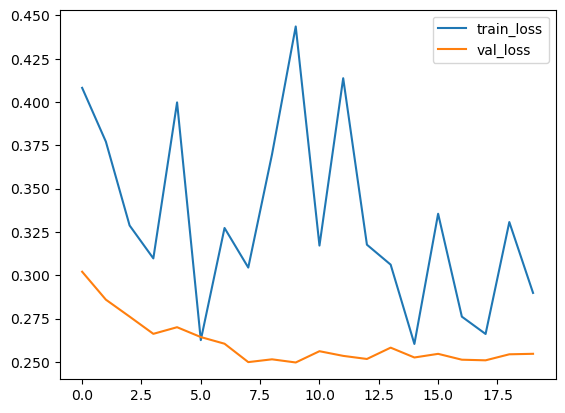

In [35]:
opt_dhs.training_log_.plot()


In [36]:
# Stratified CV
%timeit -c -n 1 -r 1
opt_dhs, opt_dhs_params, opt_dhs_search = optimize(survhive.DeepHitSingle(rng_seed=2309),  X_train, y_train)
opt_dhs.score(X_test, y_test), opt_dhs_params

(0.49224806201550386,
 {'batch_size': 16,
  'epochs': 100,
  'layer_sizes': [24, 24, 24],
  'num_durations': 10,
  'validation_size': 0.1})

In [38]:
survhive.get_top_models(opt_dhs_search)

[(1,
  0.679903369304171,
  0.06130404960108424,
  {'batch_size': 16,
   'epochs': 100,
   'layer_sizes': [24, 24, 24],
   'num_durations': 10,
   'validation_size': 0.1}),
 (2,
  0.6751875391777484,
  0.06698878529817202,
  {'batch_size': 32,
   'epochs': 100,
   'layer_sizes': [24, 24, 24],
   'num_durations': 10,
   'validation_size': 0.1}),
 (3,
  0.6379099492484774,
  0.09406721806301618,
  {'batch_size': 16,
   'epochs': 100,
   'layer_sizes': [11, 11],
   'num_durations': 10,
   'validation_size': 0.1}),
 (4,
  0.6258859182112918,
  0.09973355846102765,
  {'batch_size': 32,
   'epochs': 100,
   'layer_sizes': [11, 11],
   'num_durations': 10,
   'validation_size': 0.1}),
 (5,
  0.6234481888778655,
  0.07697892424340054,
  {'batch_size': 16,
   'epochs': 100,
   'layer_sizes': [11],
   'num_durations': 10,
   'validation_size': 0.1}),
 (6,
  0.6173458743669213,
  0.09644734884390095,
  {'batch_size': 32,
   'epochs': 100,
   'layer_sizes': [24, 24],
   'num_durations': 10,
   'va

<Axes: >

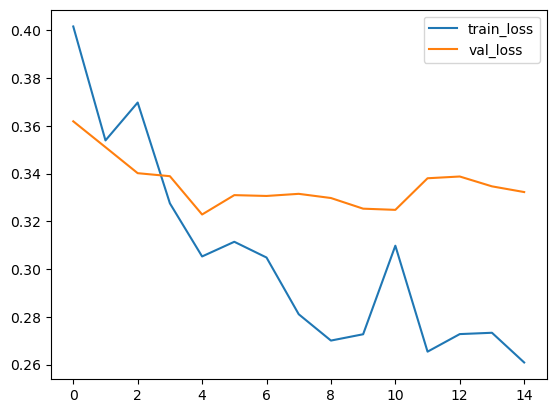

In [39]:
opt_dhs.training_log_.plot()
